<a href="https://colab.research.google.com/github/vitaliy-sharandin/data_science_projects/blob/master/portfolio/eda/Global_climate_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datasets

#### Global
* NASA's Global Climate Change Datasets
* NOAA's Climate Datasets
* WHO Air Pollution Data Portal
* Climate Change Knowledge Portal
* Climate Change Initiative
* Citizen Weather Observer Program (CWOP/APRS)

* https://ourworldindata.org/co2-and-greenhouse-gas-emissions
* https://github.com/owid/co2-data

#### Krakow
* Krakow temperatures
https://www.visualcrossing.com/weather/weather-data-services
* Krakow pollution levels
https://powietrze.gios.gov.pl/pjp/archives
* Air corridors
* https://reasonstobecheerful.world/stuttgart-ventilation-corridors-green-cool-air/
* What is direction and average speed of wind in Krakow?

# Questions
1. Temperature Changes:

  * How has the global average temperature changed over the years?
  * Are there specific regions where the temperature is rising faster?
  * What is the correlation between greenhouse gas concentration and global temperature rise?

2. Greenhouse Gas Emissions:
  * Which countries are the largest emitters of greenhouse gases, and how has this changed over time?
  * What sectors (energy, agriculture, industrial processes, etc.) contribute most to greenhouse gas emissions globally and locally?
  * How do per capita emissions vary across different countries?

3. Effects on Biodiversity:
  * How is climate change impacting biodiversity in different ecosystems?
  * Are certain species more affected than others?
  * What is the correlation between climate change and the extinction rate?

4. Climate Policies and Agreements:
  * How have different countries' emissions changed after major climate agreements (like the Paris Agreement)?
  * Are countries meeting their Nationally Determined Contributions (NDCs)?
  * How do the policies and efforts of different countries compare?

5. Extreme Weather Events:
  * Has the frequency of extreme weather events (like hurricanes, heatwaves, heavy rain) changed over time?
  * What regions are most affected by these extreme events?
  * What's the economic impact of these events?
  




* Temperature by city/country
  * https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data
  * https://climatedata.imf.org/datasets/4063314923d74187be9596f10d034914_0/explore
* Emmisions by city/country
  * https://www.kaggle.com/datasets/thedevastator/global-fossil-co2-emissions-by-country-2002-2022
  * https://ourworldindata.org/co2-and-greenhouse-gas-emissions
  * https://github.com/owid/co2-data
* Krakow temperatures
  * https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/miesieczne/klimat/
* Krakow emmisions
  * https://powietrze.gios.gov.pl/pjp/archives

In [1]:
!pip install -U -q datasets
!pip install -U -q ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 60.9 MB/s eta 0:00:00


In [249]:
import pandas as pd
from datasets import load_dataset, Dataset
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

In [300]:
global_temp_anomaly_df = load_dataset("vitaliy-sharandin/climate-global-temp-anomaly")['train'].to_pandas().set_index('dt')
country_temp_df = load_dataset("vitaliy-sharandin/climate-global-temp-country")['train'].to_pandas().set_index('dt')
krakow_temp_df = load_dataset("vitaliy-sharandin/climate-krakow-temp-monthly")['train'].to_pandas().set_index('dt')
krakow_temp_df = krakow_temp_df[~krakow_temp_df.index.duplicated(keep='first')]

pollution_region_df = load_dataset("vitaliy-sharandin/pollution-by-region")['train'].to_pandas().set_index('dt')
pollution_variation_df = load_dataset("vitaliy-sharandin/pollution-absolute-variation-co2")['train'].to_pandas().set_index('dt')

pollution_krakow_df = load_dataset("vitaliy-sharandin/pollution-krakow-no2-co")['train'].to_pandas().set_index('dt')

In [14]:
def get_monthly_to_yearly_relative_df(relative_start, relative_end, partial_year_start, partial_year_end, df):
  average_slice = df.loc[relative_start:relative_end]
  relative_average = average_slice.resample('Y').mean().mean()

  yearly_averages = df.resample('Y').mean()

  end_of_full_years = (pd.to_datetime(partial_year_start) - pd.DateOffset(months=1)).strftime('%Y-%m-%d')

  yearly_temp_df = yearly_averages.loc[:end_of_full_years] - relative_average

  partial_year_end_dt = pd.to_datetime(partial_year_end)

  partial_months_average = average_slice.loc[average_slice.index.month <= partial_year_end_dt.month].resample('Y').mean().mean()
  relative_months_df = df.loc[partial_year_start:partial_year_end] - partial_months_average

  return yearly_temp_df.append(pd.DataFrame([relative_months_df.mean()], index=[partial_year_end_dt]))

In [15]:
def get_monthly_relative_df(start, end, df):
  monthly_averages = df.loc[start:end].groupby(df.loc[start:end].index.month).mean()
  mapped_averages = df.index.map(lambda x: monthly_averages.loc[x.month])
  mapped_averages_df = pd.DataFrame(mapped_averages.tolist(), index=df.index)
  return df - mapped_averages_df

In [301]:
global_temp_anomaly_df.to_csv('global_temp.csv') # yearly diff 1961-1990
country_temp_df.to_csv('country_temp.csv') # Yearly 1951-1980

krakow_yearly_relative_temp_df = get_monthly_to_yearly_relative_df('1951-01-01', '1980-01-01','2023-01-01','2023-08-01', krakow_temp_df)
krakow_monthly_relative_temp_df = get_monthly_relative_df('1951-01-01', '1980-01-01', krakow_temp_df) # recreate to krakow average temperature 1951-1980

krakow_temp_df.to_csv('krakow_temp_df.csv')
krakow_yearly_relative_temp_df.to_csv('krakow_yearly_relative_temp_df.csv')
krakow_monthly_relative_temp_df.to_csv('krakow_monthly_relative_temp_df.csv')

pollution_region_df = pollution_region_df.pivot(columns='Entity', values='Annual CO₂ emissions')[['World','European Union (27)','Poland','United States', 'India', 'China']] # Yearly 'European Union (27)','Poland', 'United States', 'India', 'China'
pollution_variation_df = pollution_variation_df.pivot(columns='Entity', values='Annual CO₂ emissions growth (abs)')[['World','European Union (27)','Poland','United States', 'India', 'China']] # Yearly

pollution_krakow_df = pollution_krakow_df[pollution_krakow_df.index.year >= 2004]
krakow_yearly_relative_pollution_df = get_monthly_to_yearly_relative_df('2004-01-01', '2009-01-01','2023-01-01','2023-08-01', pollution_krakow_df)
krakow_monthly_relative_pollution_df = get_monthly_relative_df('2004-01-01', '2009-01-01', pollution_krakow_df) # recreate to krakow average temperature 1951-1980

pollution_region_df.to_csv('pollution_region_df.csv')
pollution_variation_df.to_csv('pollution_variation_df.csv')
pollution_krakow_df.to_csv('pollution_krakow_df.csv')
krakow_yearly_relative_pollution_df.to_csv('krakow_yearly_relative_pollution_df.csv')
krakow_monthly_relative_pollution_df.to_csv('krakow_monthly_relative_pollution_df.csv')

<ipython-input-14-3d33a4858278>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return yearly_temp_df.append(pd.DataFrame([relative_months_df.mean()], index=[partial_year_end_dt]))
<ipython-input-14-3d33a4858278>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return yearly_temp_df.append(pd.DataFrame([relative_months_df.mean()], index=[partial_year_end_dt]))


Analysis plan

1. Temperature Changes
  
  1. Global temperature change.
  
  2. Temperature change per country.
  
  3. GLobal, Poland and Krakow temperature yearly rise correlation.

2. GLobal and biggest country Greenhouse Gas Emissions
  
  1. Global emmisions amount

  2. Emmisions per country amount

  3. Relative emissions
  
  4. Correlation between global emmissions and temp

3. Krakow air pollution analysis
  
  1. Krakow monthly pollution analysis, highest/lowest.

  2. Krakow temp vs pollution correlation (inversion layer effect)


# Temperature analysis

<ipython-input-76-a8e2b2e560f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_only_df["year"] = global_only_df.index.year


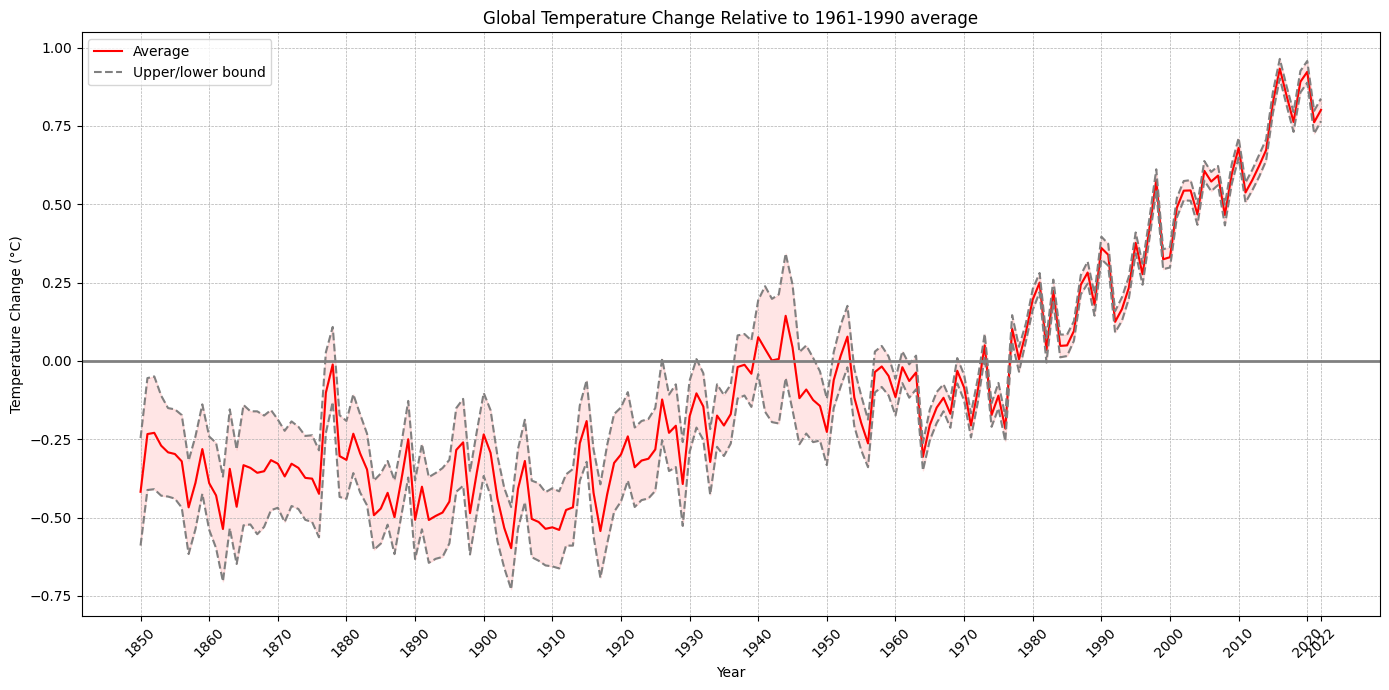

In [76]:
# Filter data for the entity "Global"
global_only_df = global_temp_anomaly_df[global_temp_anomaly_df["Entity"] == "Global"]
global_only_df["year"] = global_only_df.index.year

# Plotting
plt.figure(figsize=(14, 7))

# Column names for clarity
mean_col = "Global average temperature anomaly relative to 1961-1990"
upper_col = "Upper bound (95% confidence interval) of the annual temperature anomaly"
lower_col = "Lower bound (95% confidence interval) of the annual temperature anomaly"

# Plotting the filled areas between Upper-Mean and Lower-Mean
plt.fill_between(global_only_df.index,
                 global_only_df[mean_col],
                 global_only_df[upper_col],
                 color="red", alpha=0.1)

plt.fill_between(global_only_df.index,
                 global_only_df[mean_col],
                 global_only_df[lower_col],
                 color="red", alpha=0.1)

# Plotting the Mean, Upper, and Lower bounds
sns.lineplot(data=global_only_df, x="dt", y=mean_col, label="Average", color="red")
sns.lineplot(data=global_only_df, x="dt", y=upper_col, label="Upper/lower bound", color="grey", linestyle='--')
sns.lineplot(data=global_only_df, x="dt", y=lower_col, color="grey", linestyle='--')

ticks_df = global_only_df[(global_only_df['year'] % 10 == 0) | (global_only_df['year'] == global_only_df['year'].max())]

plt.axhline(0, color='grey', linestyle='-', linewidth=2)  # 0 value line
plt.title("Global Temperature Change Relative to 1961-1990 average")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ticks_df.index, ticks_df['year'],rotation=45)  # Rotate x-axis labels to 45 degrees
plt.tight_layout()
plt.show()

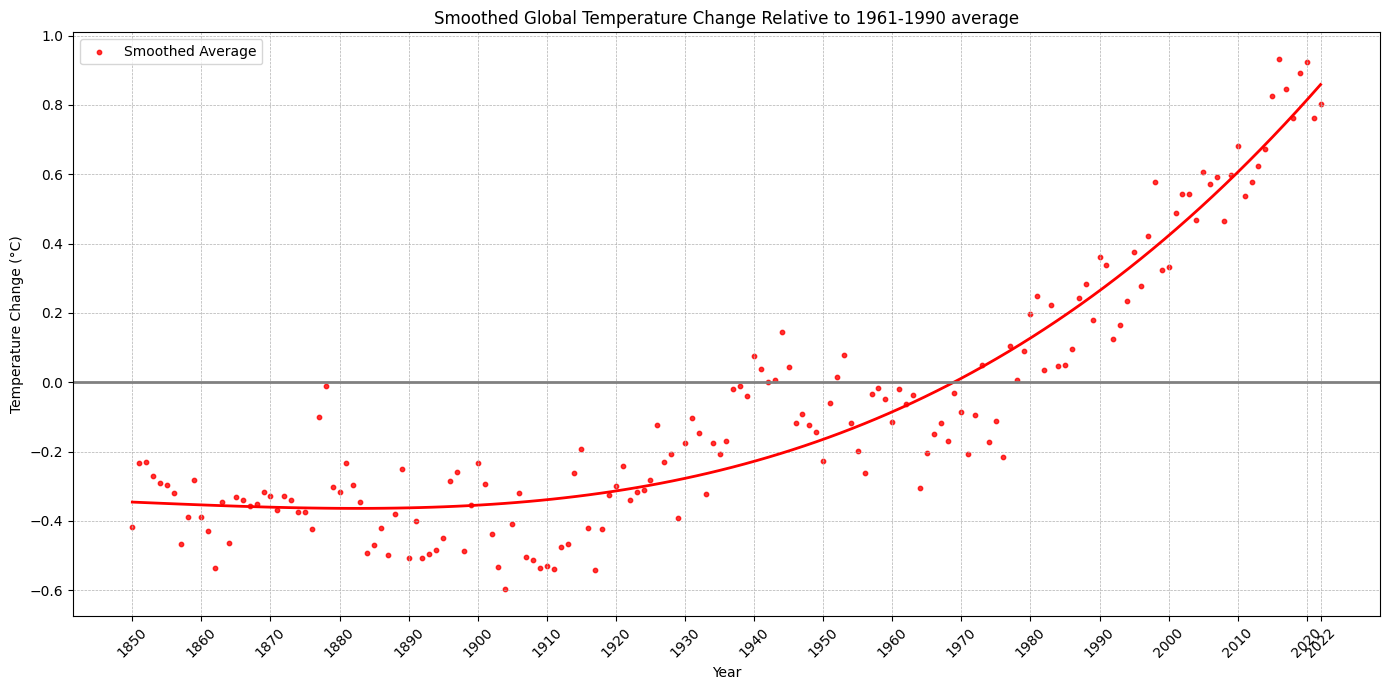

In [77]:
# Now, plotting the smoothed trend line using regplot
plt.figure(figsize=(14, 7))

# Using regplot to plot the smoothed trend line
sns.regplot(data=global_only_df, x="year", y="Global average temperature anomaly relative to 1961-1990", label="Smoothed Average", color="red", scatter=True, scatter_kws={"s": 10}, order=3, ci=None, line_kws={'lw': 2})

plt.axhline(0, color='grey', linestyle='-', linewidth=2)  # 0 value line
plt.title("Smoothed Global Temperature Change Relative to 1961-1990 average")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ticks_df["year"], rotation=45)  # Rotate x-axis labels to 45 degrees
plt.tight_layout()
plt.show()

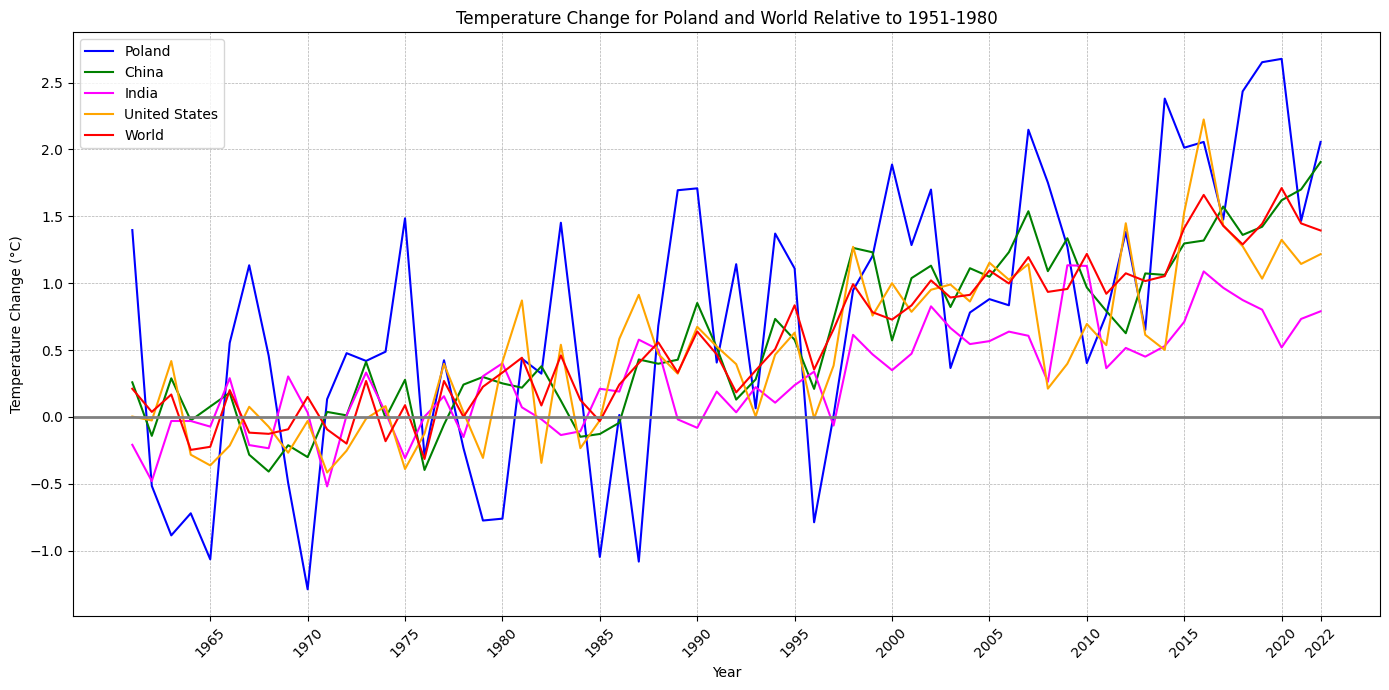

In [63]:
# Color palette for better differentiation
palette = {
    'Poland': 'blue',
    'China': 'green',
    'India': 'magenta',
    'United States': 'orange',
    'World': 'red'
}

# Filtering the dataframe for every 10th year and the last year for country_temp_df
ticks_df_country = country_temp_df[(country_temp_df["Year"] % 5 == 0) | (country_temp_df["Year"] == country_temp_df["Year"].max())]

# Plotting temperature change for Poland and the World with distinct colors
plt.figure(figsize=(14, 7))

for country, color in palette.items():
    sns.lineplot(data=country_temp_df, x="Year", y=country, label=country, color=color)

plt.axhline(0, color='grey', linestyle='-', linewidth=2)  # 0 value line
plt.xticks(ticks_df_country["Year"].unique(), rotation=45)
plt.title("Temperature Change for Poland and World Relative to 1951-1980")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


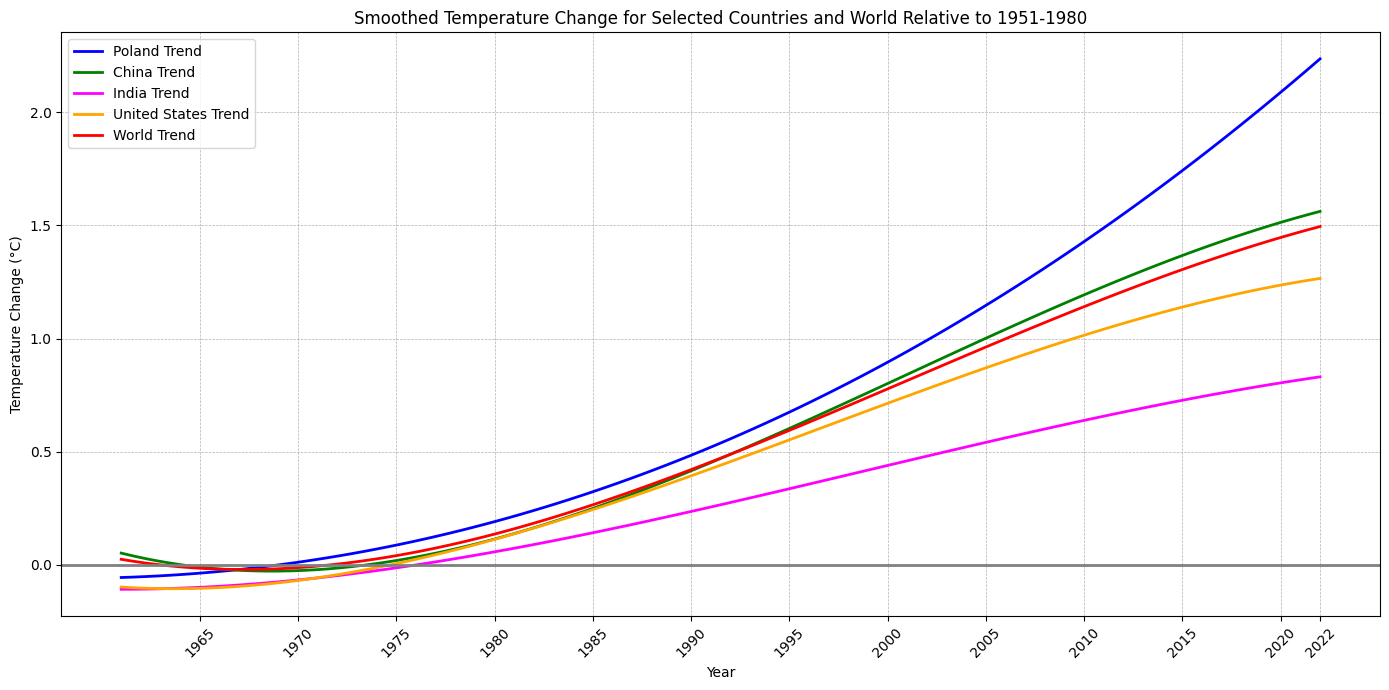

In [65]:
plt.figure(figsize=(14, 7))

for country, color in palette.items():
    # Using a regression plot (regplot) to plot the smoothed trend line
    sns.regplot(data=country_temp_df, x="Year", y=country, label=f"{country} Trend", color=color, scatter=False, order=3, ci=None, line_kws={'lw': 2})

plt.axhline(0, color='grey', linestyle='-', linewidth=2)  # 0 value line
plt.xticks(ticks_df_country["Year"].unique(), rotation=45)
plt.title("Smoothed Temperature Change for Selected Countries and World Relative to 1951-1980")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

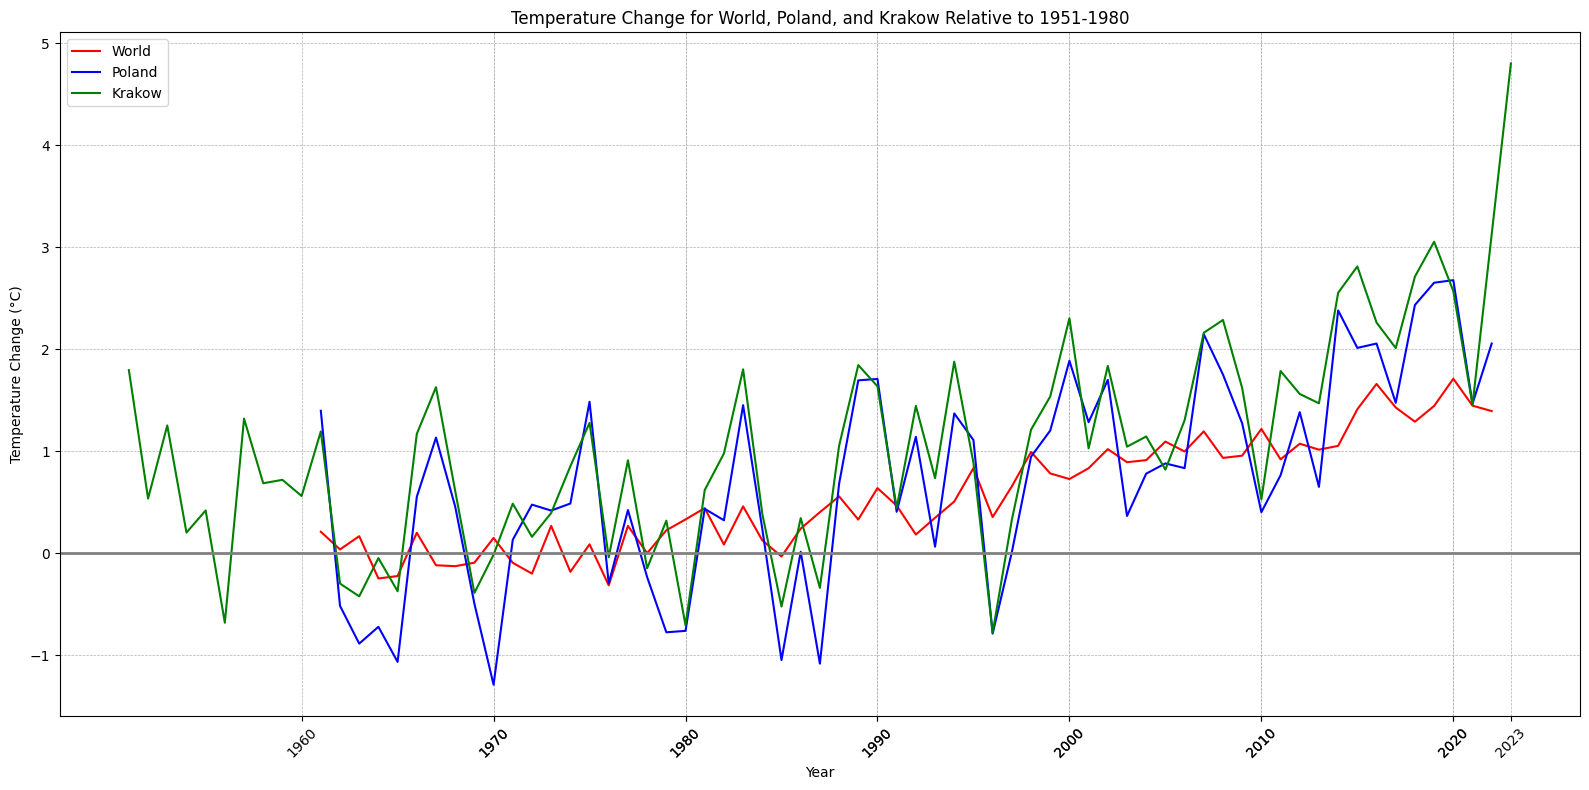

In [79]:
krakow_yearly_relative_temp_df["year"] = krakow_yearly_relative_temp_df.index.year

# Plotting temperature change for World, Poland, and Krakow
plt.figure(figsize=(16, 8))

# Defining a new color palette
palette_extended = {
    'World': 'red',
    'Poland': 'blue',
    'Krakow': 'green'
}

# Plotting for World and Poland from country_temp_df
for country, color in palette_extended.items():
    if country in ['World', 'Poland']:
        sns.lineplot(data=country_temp_df, x="Year", y=country, label=country, color=color)

# Plotting for Krakow from krakow_temp_df
sns.lineplot(data=krakow_yearly_relative_temp_df, x="year", y="Average monthly temperature [°C]", label="Krakow", color=palette_extended["Krakow"])

# Setting x-ticks to every 10th year and the last year
all_years = country_temp_df["Year"].unique().tolist() + krakow_yearly_relative_temp_df["year"].unique().tolist()
ticks_years = [year for year in all_years if year % 10 == 0] + [max(all_years)]

plt.axhline(0, color='grey', linestyle='-', linewidth=2)  # 0 value line
plt.xticks(ticks_years, rotation=45)
plt.title("Temperature Change for World, Poland, and Krakow Relative to 1951-1980")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


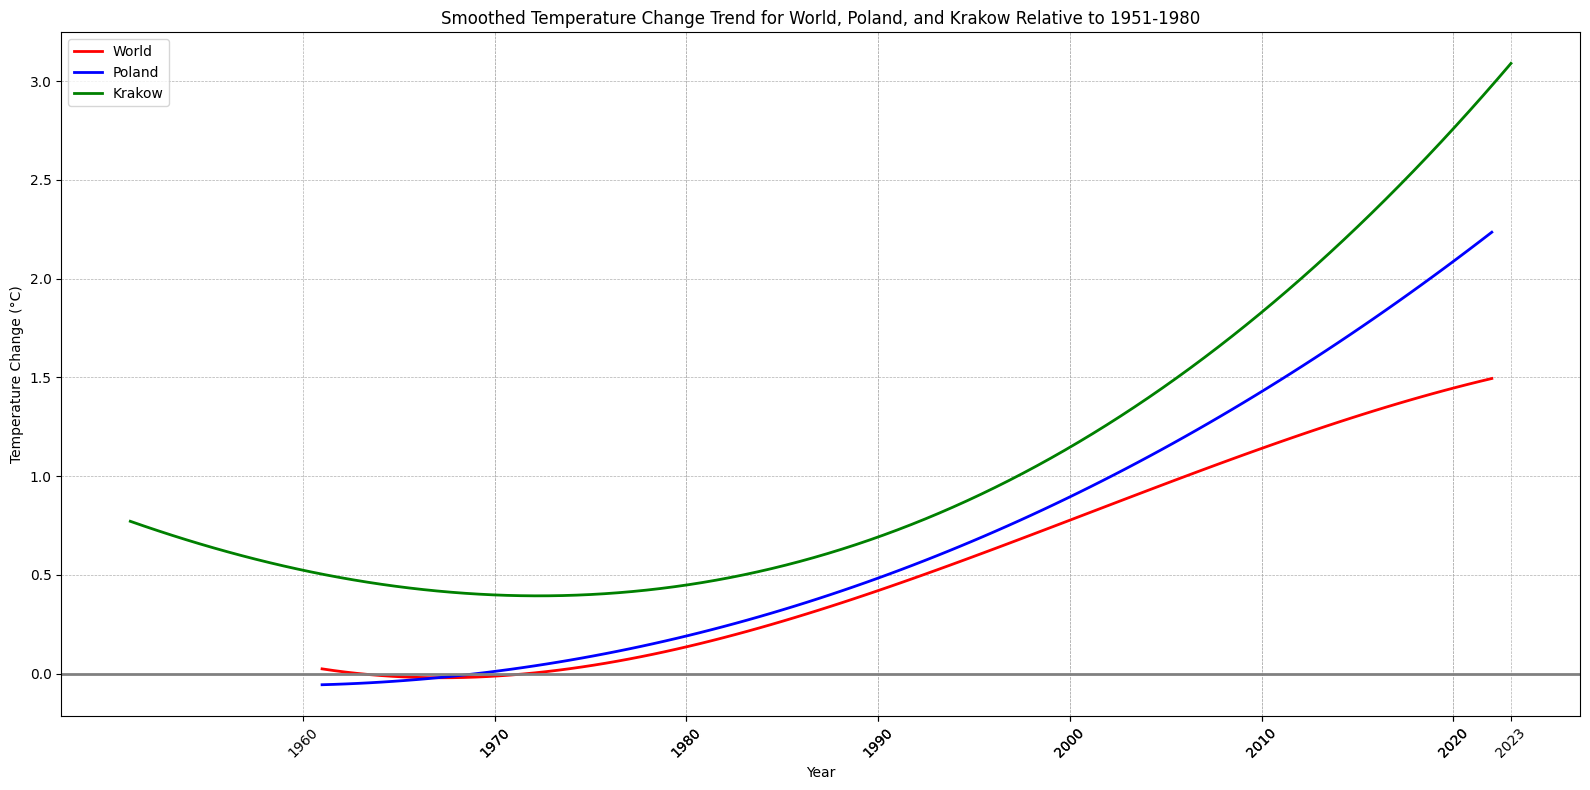

In [84]:
plt.figure(figsize=(16, 8))

# Plotting smoothed trend lines for World, Poland, and Krakow without confidence intervals
for country, color in palette_extended.items():
    if country in ['World', 'Poland']:
        sns.regplot(data=country_temp_df, x="Year", y=country, label=country, color=color, scatter=False, order=3, ci=None, line_kws={'lw': 2})
    else:  # For Krakow
        sns.regplot(data=krakow_yearly_relative_temp_df, x="year", y="Average monthly temperature [°C]", label="Krakow", color=color, scatter=False, order=3, ci=None, line_kws={'lw': 2})

plt.axhline(0, color='grey', linestyle='-', linewidth=2)  # 0 value line
plt.xticks(ticks_years, rotation=45)
plt.title("Smoothed Temperature Change Trend for World, Poland, and Krakow Relative to 1951-1980")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


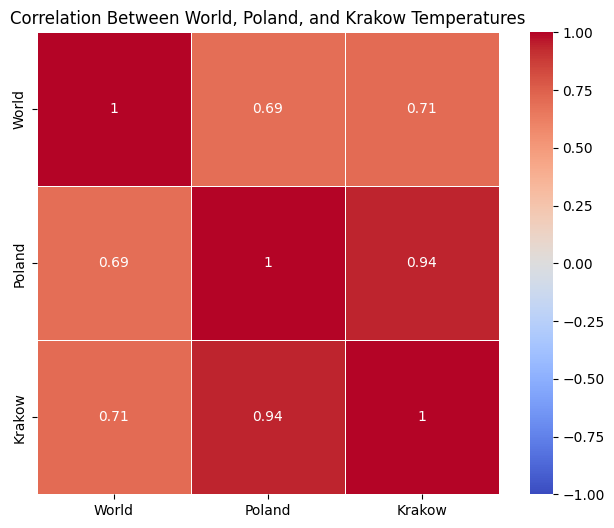

In [93]:
# Merging the datasets on the year
merged_df = pd.merge(country_temp_df[['Year', 'World', 'Poland']], krakow_yearly_relative_temp_df[['year', 'Average monthly temperature [°C]']], left_on="Year", right_on="year", how="inner")

# Drop redundant columns
merged_df.drop(columns=['year'], inplace=True)
merged_df.rename(columns={'Average monthly temperature [°C]': 'Krakow'}, inplace=True)

# Compute the correlation matrix
correlation_matrix = merged_df[['World', 'Poland', 'Krakow']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title("Correlation Between World, Poland, and Krakow Temperatures")
plt.show()

# CO2 greenhouse gas emission and it's influence on temperature

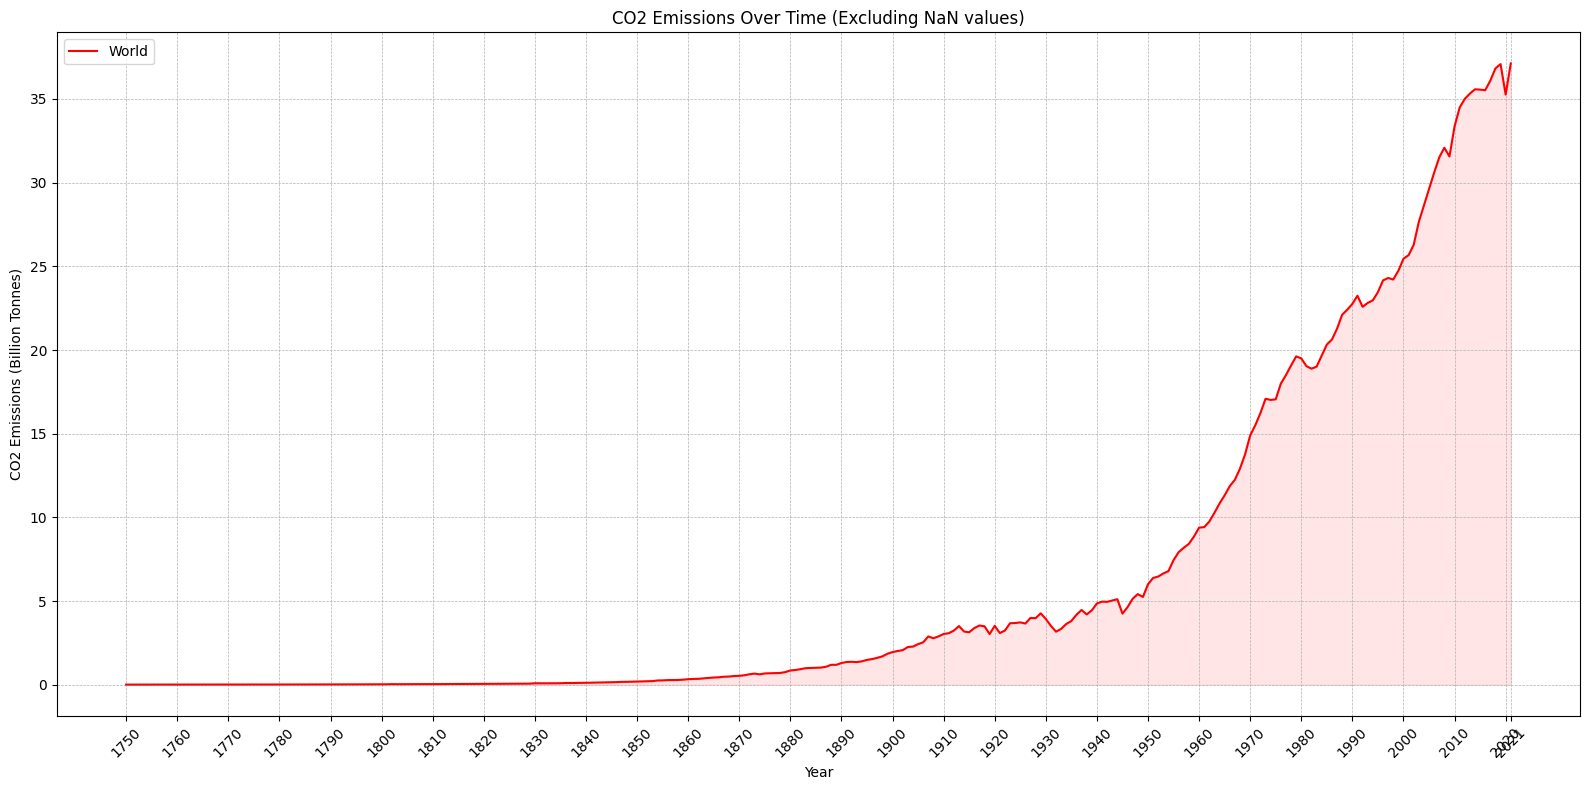

In [116]:
# Define countries and colors
country_color_dict = {
    "World": "red"
}

# Removing rows with NaN values for all countries
pollution_region_df_clean = pollution_region_df.dropna(subset=list(country_color_dict.keys()), how='all')

# Extracting the dates for every 10th year and the last year from the cleaned dataset
all_years = pollution_region_df_clean.index.year.unique()
ticks_years = [year for year in all_years if year % 10 == 0] + [max(all_years)]
tick_dates_clean = pollution_region_df_clean[pollution_region_df_clean.index.year.isin(ticks_years)].index.unique()

plt.figure(figsize=(16, 8))

# Plotting data for each country/region using the cleaned dataset
for country, color in country_color_dict.items():
    data_values = pollution_region_df_clean[country] / 1e9  # Dividing by 1e9 to convert to billion tonnes
    sns.lineplot(data=pollution_region_df_clean, x=pollution_region_df_clean.index, y=data_values, label=country, color=color)
    # Filling the area between each line and the x-axis with a translucent version of the line color
    plt.fill_between(pollution_region_df_clean.index, data_values, color=color, alpha=0.1)

plt.title("CO2 Emissions Over Time (Excluding NaN values)")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (Billion Tonnes)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Setting x-ticks to the extracted dates from the cleaned dataset and rotating them by 45 degrees
plt.xticks(tick_dates_clean, labels=[date.year for date in tick_dates_clean], rotation=45)

plt.tight_layout()
plt.show()

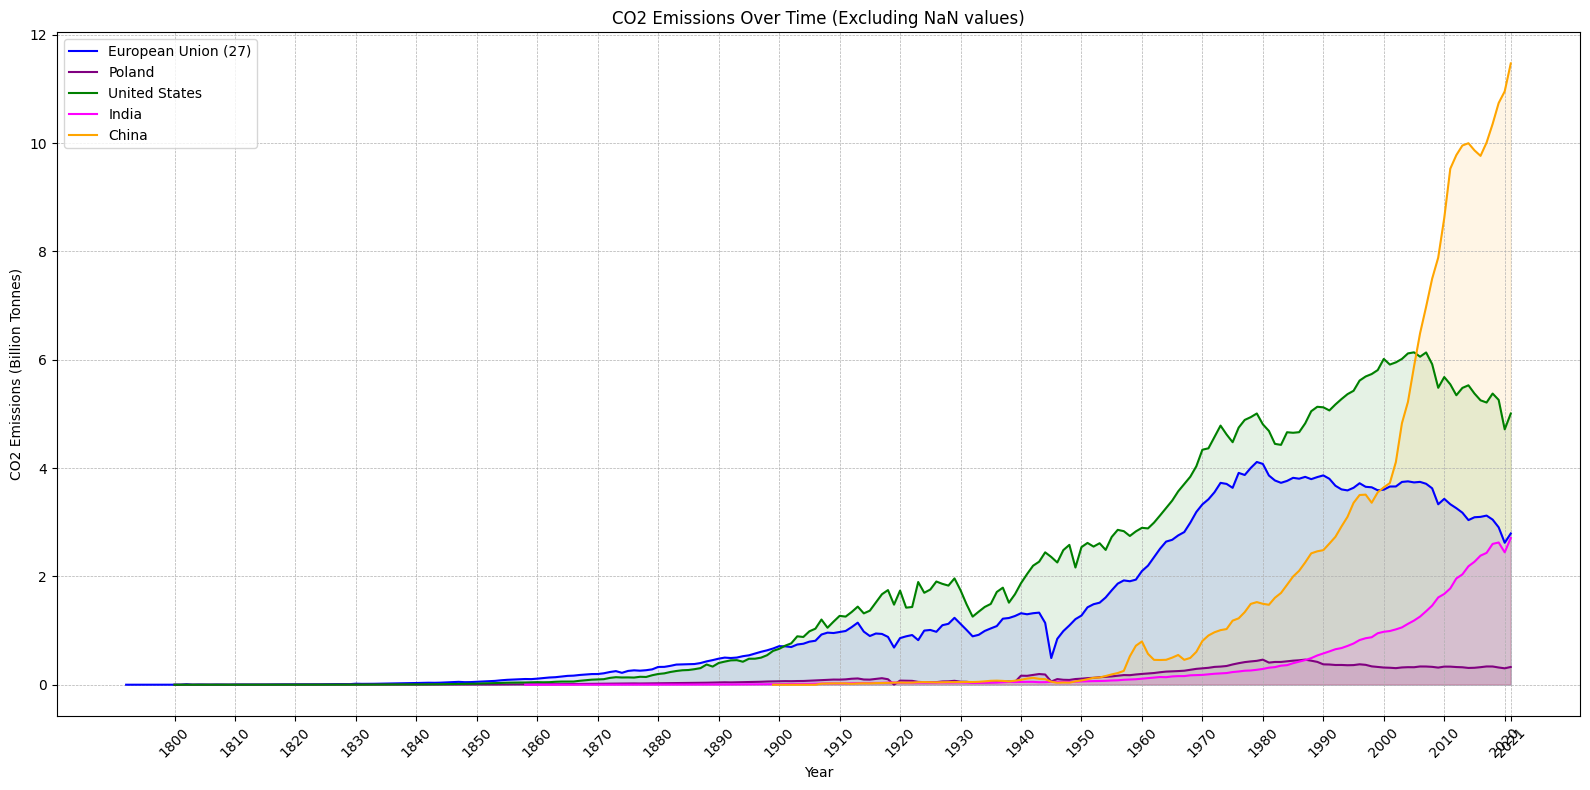

In [115]:
# Define countries and colors
country_color_dict = {
    "European Union (27)": "blue",
    "Poland": "purple",
    "United States": "green",
    "India": "magenta",
    "China": "orange"
}

# Removing rows with NaN values for all countries
pollution_region_df_clean = pollution_region_df.dropna(subset=list(country_color_dict.keys()), how='all')

# Extracting the dates for every 10th year and the last year from the cleaned dataset
all_years = pollution_region_df_clean.index.year.unique()
ticks_years = [year for year in all_years if year % 10 == 0] + [max(all_years)]
tick_dates_clean = pollution_region_df_clean[pollution_region_df_clean.index.year.isin(ticks_years)].index.unique()

plt.figure(figsize=(16, 8))

# Plotting data for each country/region using the cleaned dataset
for country, color in country_color_dict.items():
    data_values = pollution_region_df_clean[country] / 1e9  # Dividing by 1e9 to convert to billion tonnes
    sns.lineplot(data=pollution_region_df_clean, x=pollution_region_df_clean.index, y=data_values, label=country, color=color)
    # Filling the area between each line and the x-axis with a translucent version of the line color
    plt.fill_between(pollution_region_df_clean.index, data_values, color=color, alpha=0.1)

plt.title("CO2 Emissions Over Time (Excluding NaN values)")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (Billion Tonnes)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Setting x-ticks to the extracted dates from the cleaned dataset and rotating them by 45 degrees
plt.xticks(tick_dates_clean, labels=[date.year for date in tick_dates_clean], rotation=45)

plt.tight_layout()
plt.show()


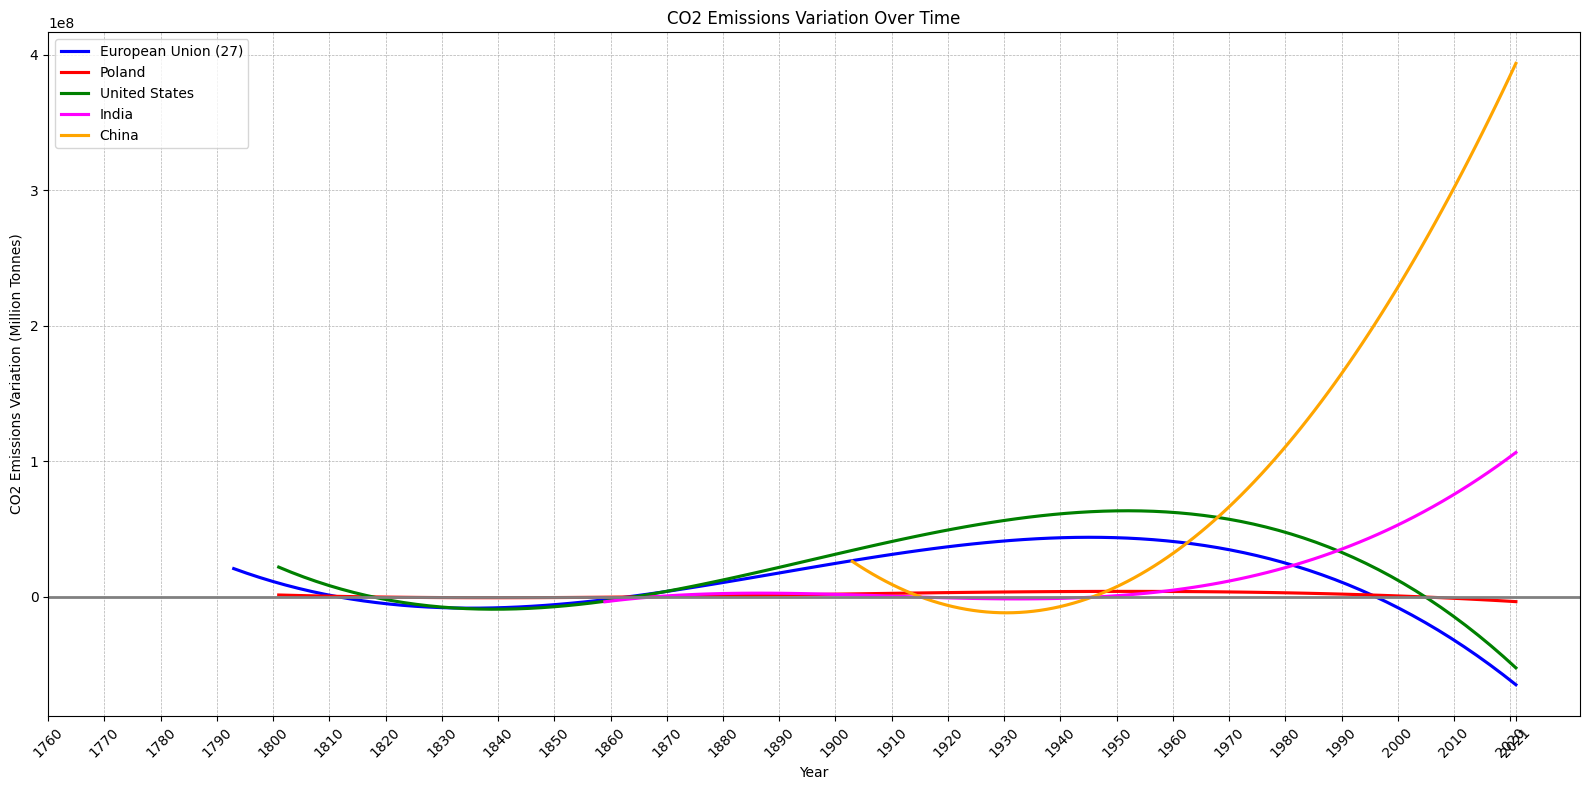

In [173]:
# Define countries and colors
country_color_dict = {
    "European Union (27)": "blue",
    "Poland": "red",
    "United States": "green",
    "India": "magenta",
    "China": "orange"
}

# Extracting the dates for every 10th year and the last year from the dataset
all_years = pollution_variation_df.index.year.unique()
ticks_years = [year for year in all_years if year % 10 == 0] + [max(all_years)]

plt.figure(figsize=(16, 8))

# Plotting variation data for each country/region using regplot
for country, color in country_color_dict.items():
    x_values = pollution_variation_df.index.year
    y_values = pollution_variation_df[country]

    sns.regplot(x=x_values, y=y_values,
                label=country, color=color, scatter=False, ci=None, order=3)

plt.axhline(0, color='grey', linestyle='-', linewidth=2)  # 0 value line
plt.title("CO2 Emissions Variation Over Time")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions Variation (Million Tonnes)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ticks_years, rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-205-e34eae719b82>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_temp_filtered['Year'] = global_temp_filtered.index.year


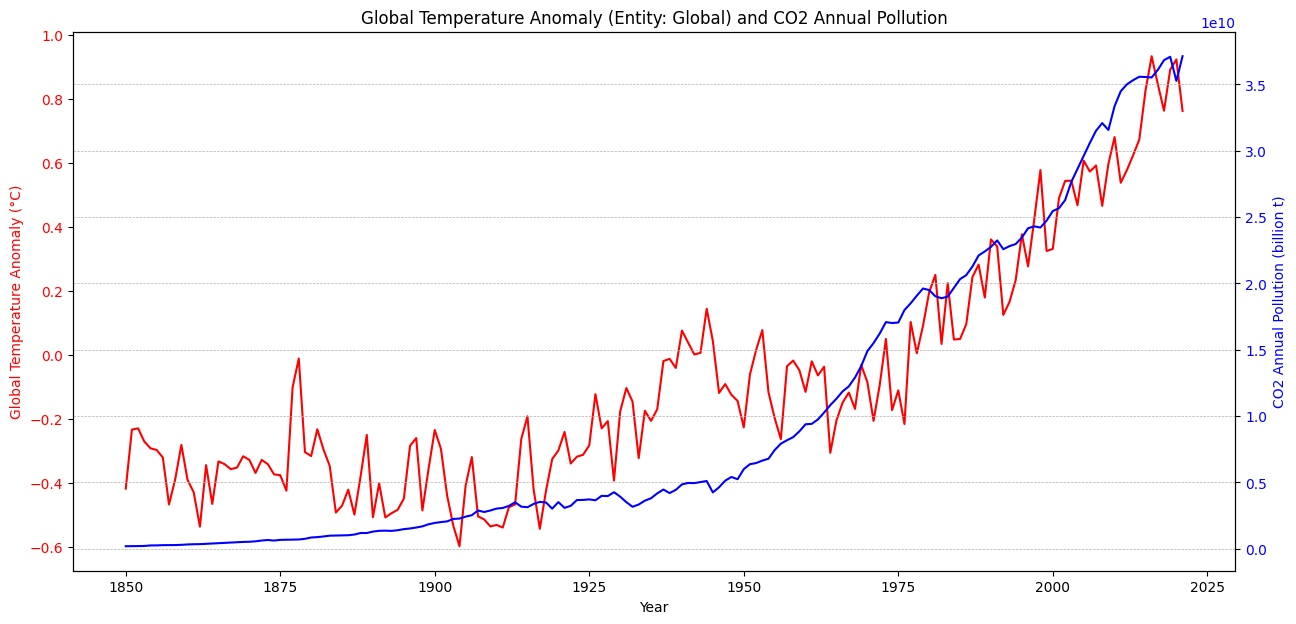

In [205]:
# Filter global_temp_df to include only rows with 'Entity' as 'Global'
global_temp_filtered = global_temp_anomaly_df[global_temp_anomaly_df['Entity'] == 'Global']
global_temp_filtered['Year'] = global_temp_filtered.index.year
pollution_region_df['Year'] = pollution_region_df.index.year
pollution_region_df_corr = pollution_region_df[['Year', 'World']]

# Merge the global temperature data with the updated pollution data on 'Year'
merged_df_updated = pd.merge(global_temp_filtered, pollution_region_df_corr, on='Year', how='inner')

# Plotting the trends
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plotting global temperature anomaly on the left y-axis
ax1.set_xlabel('Year')
ax1.set_ylabel('Global Temperature Anomaly (°C)', color='red')
ax1.plot(merged_df_updated['Year'], merged_df_updated['Global average temperature anomaly relative to 1961-1990'], color='red', label='Temperature Anomaly')
ax1.tick_params(axis='y', labelcolor='red')

# Creating a second y-axis to plot pollution variation
ax2 = ax1.twinx()
ax2.set_ylabel('CO2 Annual Pollution (billion t)', color='blue')
ax2.plot(merged_df_updated['Year'], merged_df_updated['World'], color='blue', label='CO2 Annual Pollution (billion t)')
ax2.tick_params(axis='y', labelcolor='blue')

# Setting the title and displaying the plot
plt.title('Global Temperature Anomaly (Entity: Global) and CO2 Annual Pollution')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


<Figure size 1200x800 with 0 Axes>

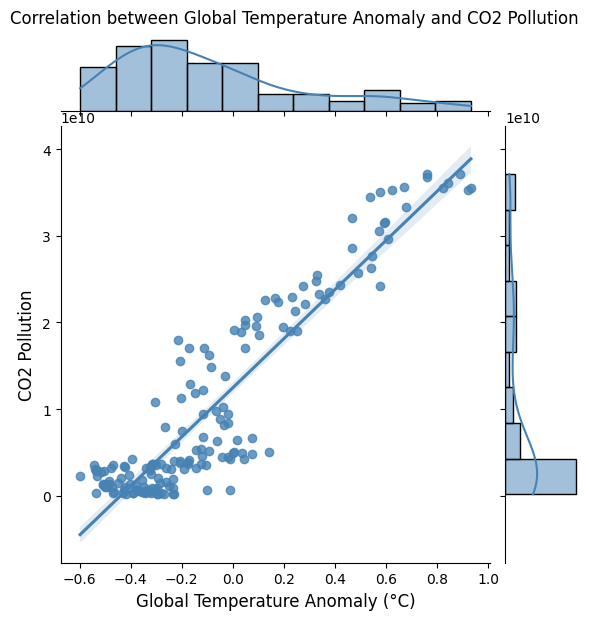

0.9221707125570543

In [210]:
# Plotting the correlation with an updated color palette
plt.figure(figsize=(12, 8))
sns_plot = sns.jointplot(data=merged_df_updated,
                         x='Global average temperature anomaly relative to 1961-1990',
                         y='World',
                         kind='reg',
                         color='steelblue')
sns_plot.set_axis_labels('Global Temperature Anomaly (°C)', 'CO2 Pollution', fontsize=12)
plt.suptitle('Correlation between Global Temperature Anomaly and CO2 Pollution', y=1.02)
plt.show()
merged_df_updated[['Global average temperature anomaly relative to 1961-1990', 'World']].corr().iloc[0, 1]

Correlation between global emmissions and temp

Krakow air pollution analysis

Krakow monthly pollution analysis, highest/lowest.

Krakow temp vs pollution correlation (inversion layer effect)

In [ ]:
krakow_monthly_relative_pollution_df # trend
pollution_krakow_df # seasonal decomposition and analysis
krakow_monthly_relative_temp_df # corr

# Krakow pollution analysis

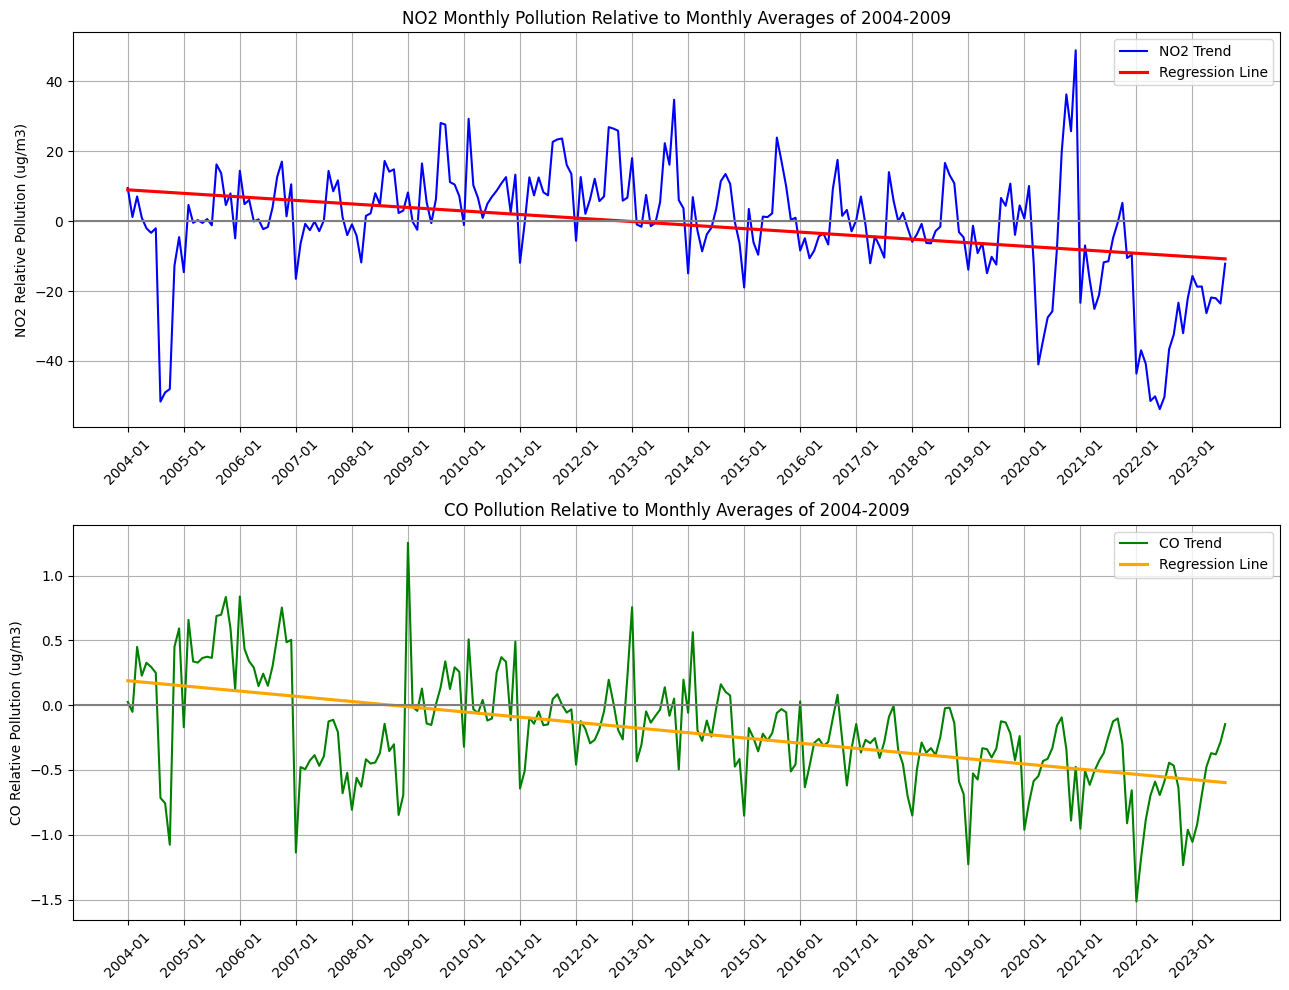

In [237]:
# Setting up the figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 10))

# Plotting for NO2
sns.lineplot(x=np.arange(len(krakow_monthly_relative_pollution_df)), y='NO2', data=krakow_monthly_relative_pollution_df, ax=ax1, label='NO2 Trend', color='blue')
sns.regplot(x=np.arange(len(krakow_monthly_relative_pollution_df)), y='NO2', data=krakow_monthly_relative_pollution_df, ax=ax1, scatter=False, ci=False, color='red', label='Regression Line')
ax1.axhline(0, color='grey', linestyle='-')  # Grey line at y=0
ax1.set_title('Monthly NO2 Monthly Pollution Relative to Monthly Averages of 2004-2009')
ax1.set_ylabel('NO2 Relative Pollution (ug/m3)')
ax1.set_xticks(np.arange(0, len(krakow_monthly_relative_pollution_df), 12))
ax1.set_xticklabels(krakow_monthly_relative_pollution_df.index.strftime('%Y-%m').tolist()[::12], rotation=45)
ax1.grid(True)  # Adding grid
ax1.legend()

# Plotting for CO
sns.lineplot(x=np.arange(len(krakow_monthly_relative_pollution_df)), y='CO', data=krakow_monthly_relative_pollution_df, ax=ax2, label='CO Trend', color='green')
sns.regplot(x=np.arange(len(krakow_monthly_relative_pollution_df)), y='CO', data=krakow_monthly_relative_pollution_df, ax=ax2, scatter=False, ci=False, color='orange', label='Regression Line')
ax2.axhline(0, color='grey', linestyle='-')  # Grey line at y=0
ax2.set_title('CO Pollution Relative to Monthly Averages of 2004-2009')
ax2.set_ylabel('Monthly CO Relative Pollution (ug/m3)')
ax2.set_xticks(np.arange(0, len(krakow_monthly_relative_pollution_df), 12))
ax2.set_xticklabels(krakow_monthly_relative_pollution_df.index.strftime('%Y-%m').tolist()[::12], rotation=45)
ax2.grid(True)  # Adding grid
ax2.legend()

plt.tight_layout()
plt.show()


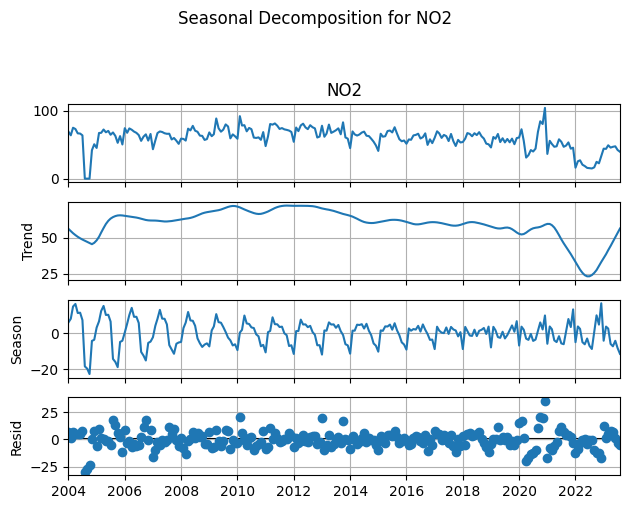

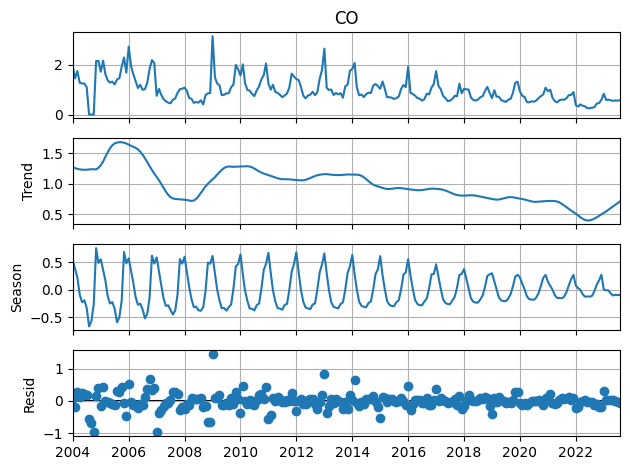

In [243]:
# Seasonal Decomposition for NO2
stl_NO2 = STL(pollution_krakow_df['NO2'], seasonal=13).fit()
fig_NO2 = stl_NO2.plot()
for ax in fig_NO2.get_axes():
    ax.grid(True)
fig_NO2.suptitle('Seasonal Decomposition for NO2 and CO', y=1.05)
plt.tight_layout()
plt.show()

# Seasonal Decomposition for CO
stl_CO = STL(pollution_krakow_df['CO'], seasonal=13).fit()
fig_CO = stl_CO.plot()
for ax in fig_CO.get_axes():
    ax.grid(True)
plt.tight_layout()
plt.show()

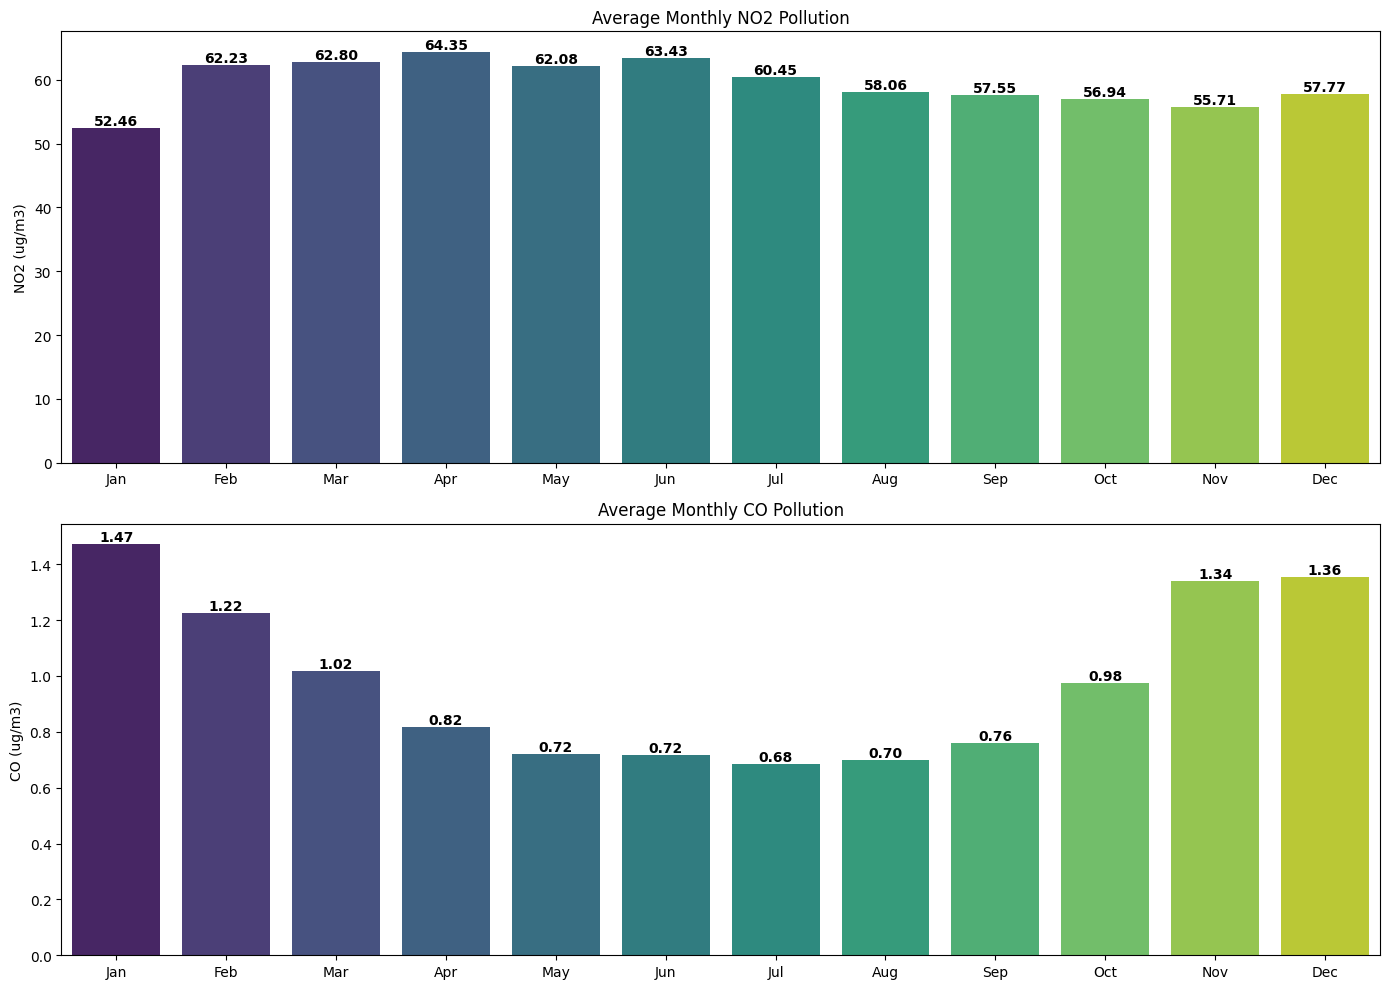

In [244]:
# Extracting month from the index to analyze monthly patterns
pollution_krakow_df['month'] = pollution_krakow_df.index.month

# Grouping by month to get the average pollution for each month
monthly_avg_NO2 = pollution_krakow_df.groupby('month')['NO2'].mean()
monthly_avg_CO = pollution_krakow_df.groupby('month')['CO'].mean()

# Plotting the monthly average pollution for NO2 and CO
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# NO2
sns.barplot(x=months, y=monthly_avg_NO2, ax=ax1, palette="viridis")
ax1.set_title('Average Monthly NO2 Pollution')
ax1.set_ylabel('NO2 (ug/m3)')
for idx, value in enumerate(monthly_avg_NO2):
    ax1.text(idx, value, f"{value:.2f}", ha="center", va="bottom", fontweight='bold')

# CO
sns.barplot(x=months, y=monthly_avg_CO, ax=ax2, palette="viridis")
ax2.set_title('Average Monthly CO Pollution')
ax2.set_ylabel('CO (ug/m3)')
for idx, value in enumerate(monthly_avg_CO):
    ax2.text(idx, value, f"{value:.2f}", ha="center", va="bottom", fontweight='bold')

plt.tight_layout()
plt.show()


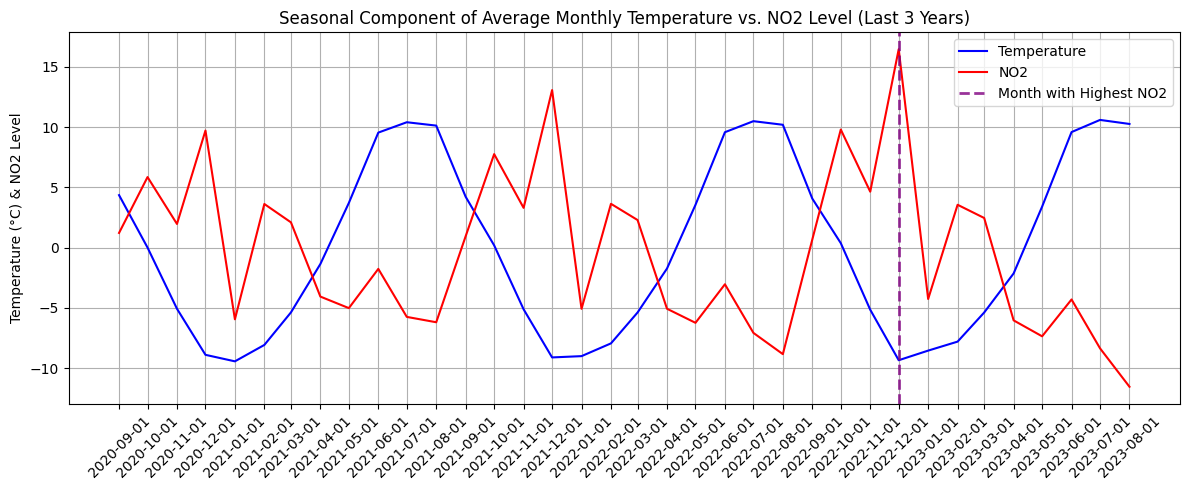

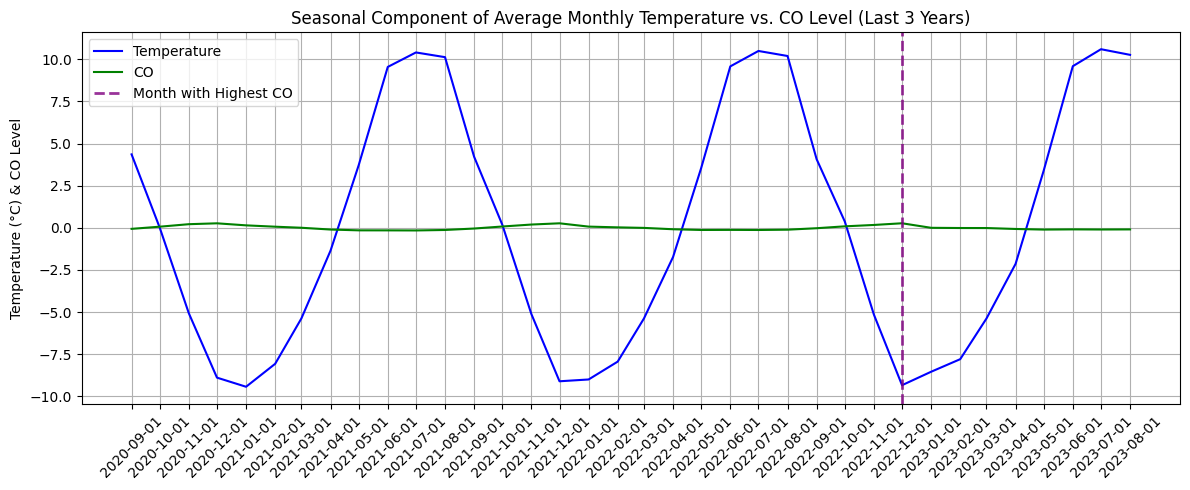

In [306]:
# Decomposing the temperature data
stl_temp = STL(krakow_temp_df['Average monthly temperature [°C]'], seasonal=13).fit()
seasonal_temp = stl_temp.seasonal

# Decomposing the NO2 pollution data
stl_NO2 = STL(pollution_krakow_df['NO2'], seasonal=13).fit()
seasonal_NO2 = stl_NO2.seasonal

# Decomposing the CO pollution data
stl_CO = STL(pollution_krakow_df['CO'], seasonal=13).fit()
seasonal_CO = stl_CO.seasonal

# Extract the last three years
last_three_years = pd.date_range(start=krakow_temp_df.index[-36], end=krakow_temp_df.index[-1], freq='MS')
seasonal_temp_3y = seasonal_temp[last_three_years]
seasonal_NO2_3y = seasonal_NO2[last_three_years]
seasonal_CO_3y = seasonal_CO[last_three_years]

# Identifying the exact dates within the last three years with the highest seasonal values for NO2 and CO
date_with_highest_NO2 = seasonal_NO2_3y.idxmax()
date_with_highest_CO = seasonal_CO_3y.idxmax()

# Plotting Temperature vs. NO2 Levels
plt.figure(figsize=(12, 5))
plt.plot(seasonal_temp_3y.index, seasonal_temp_3y, label='Temperature Seasonal Component', color='blue')
plt.plot(seasonal_NO2_3y.index, seasonal_NO2_3y, label='NO2 Seasonal Component', color='red')
plt.axvline(date_with_highest_NO2, color='purple', alpha=0.8, linestyle='--', linewidth=2)
plt.title('Seasonal Component of Average Monthly Temperature vs. NO2 Level (Last 3 Years)')
plt.ylabel('Temperature (°C) & NO2 Level')
plt.grid(True)
plt.xticks(last_three_years, rotation=45)
plt.legend(['Temperature', 'NO2', 'Month with Highest NO2'])
plt.tight_layout()
plt.show()

# Plotting Temperature vs. CO Levels
plt.figure(figsize=(12, 5))
plt.plot(seasonal_temp_3y.index, seasonal_temp_3y, label='Temperature Seasonal Component', color='blue')
plt.plot(seasonal_CO_3y.index, seasonal_CO_3y, label='CO Seasonal Component', color='green')
plt.axvline(date_with_highest_CO, color='purple', alpha=0.8, linestyle='--', linewidth=2)
plt.title('Seasonal Component of Average Monthly Temperature vs. CO Level (Last 3 Years)')
plt.ylabel('Temperature (°C) & CO Level')
plt.grid(True)
plt.xticks(last_three_years, rotation=45)
plt.legend(['Temperature', 'CO', 'Month with Highest CO'])
plt.tight_layout()
plt.show()

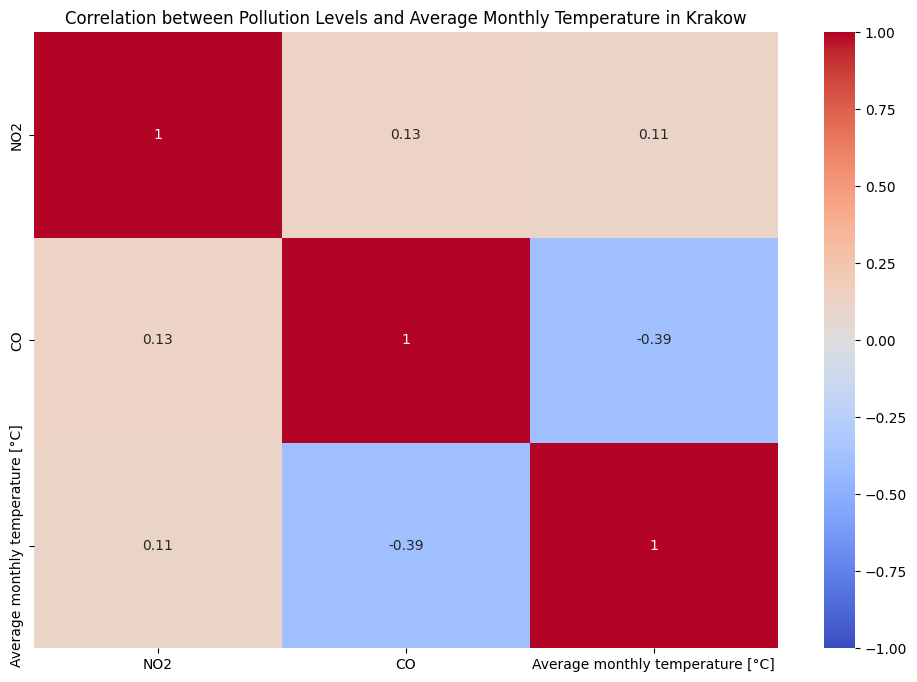

In [296]:
# Merging the two dataframes on the datetime index to align the data
merged_df = pd.merge(pollution_krakow_df, krakow_temp_df[['Average monthly temperature [°C]']], left_index=True, right_index=True)

# Calculating correlation matrix
correlation_matrix = merged_df.corr()

# Plotting the heatmap to visualize the correlation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation between Pollution Levels and Average Monthly Temperature in Krakow')
plt.show()
